## 설명
- 해당 오토인코더는 Convolution 신경망과 Deep 신경망을 결합한 2D AutoEncoder이다.
- 학습 데이터는 사람 얼굴 1만장, 웹툰 등장인물 얼굴 1만장이다.
- 기대효과는 Convolution 신경망을 통한 피쳐추출과 Deep AutoEncoder 구조를 결합하여 특징 벡터를 보다 잘 추출하는데 있다.

## 1. 텐서플로우 메모리 관리
- 텐서플로우의 경우에 사용가능한 메모리를 모두 독점하는 특징이 있기 때문에 stack 방식으로 메모리를 관리하여 필요한 메모리만큼 할당하는 코드이다.

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

2022-08-07 21:30:16.594332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 21:30:16.622433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 21:30:16.625145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## 2. 패키지 로드

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

## 3. 데이터 로드

In [3]:
# 데이터 로드
human_image_datas = glob('./image_human/*.jpg')
webtoon_image_datas = glob('./image_webtoon/*.jpg')

In [4]:
# 데이터 크기 확인
len(human_image_datas), len(webtoon_image_datas)

(10456, 27702)

## 4. 이미지 전처리

In [5]:
data_set = [human_image_datas, webtoon_image_datas[:10456]]
X = []

for data in tqdm(data_set):
    for image_name in tqdm(data):
        image = cv2.imread(image_name, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (64, 64))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        X.append(image)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10456 [00:00<?, ?it/s]

  0%|          | 0/10456 [00:00<?, ?it/s]

In [8]:
# Numpy 배열로 변경
X = np.array(X)

In [9]:
X = X.astype(np.float32) / 255.

In [10]:
# train data 와 test data로 나누기
train_images, test_images = train_test_split(X, test_size=0.1, shuffle=True, random_state = 41)

In [11]:
# shape 확인
train_images.shape, test_images.shape

((18820, 64, 64, 3), (2092, 64, 64, 3))

## 5. AutoEncoder 모델 생성

### 1) Parameters 설정

In [12]:
# params 설정
learning_rate = 0.01
epochs = 1000
batch_size = 64
latent_dim = 768

In [17]:
# 모델 클래스 정의
class AutoEncoder(Model):
    def __init__(self, latent_dim):
        super(AutoEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        # 인코더 정의
        self.encoder = tf.keras.Sequential([
            Input(shape=(64, 64, 3)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(16, (3, 3), activation='relu', padding='same'),
            Flatten(),
            Dense(latent_dim, activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            Reshape((16, 16, 3)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(3, (3, 3), activation='sigmoid', padding='same')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

### 2) 모델 생성 및 컴파일
- 모델의 loss 함수는 재구성 오류를 확인하기 위해 mse로 설정한다.

In [18]:
# 모델 생성 및 컴파일
model = AutoEncoder(latent_dim)
model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mse'])
checkpointer = ModelCheckpoint(filepath='./2D_AutoEncoder_model/2D_AutoEncoder.ckpt', 
                               verbose=1, save_best_only=True, save_weights_only=True, monitor='val_mse', mode='min')
earlystopping = EarlyStopping(monitor='val_mse', mode='min', verbose=1, patience=50)

## 6. AutoEncoder Model 학습
- AutoEncoder Model의 학습에서 x값과 y값은 동일하다.

In [20]:
history = model.fit(train_images, train_images,
                epochs=epochs,
                shuffle=True,
                validation_data=(test_images, test_images), workers=3, callbacks=[checkpointer, earlystopping], batch_size=batch_size)

2022-08-07 21:43:53.039639: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 925040640 exceeds 10% of free system memory.
2022-08-07 21:43:53.933202: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 925040640 exceeds 10% of free system memory.
2022-08-07 21:43:54.851946: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 925040640 exceeds 10% of free system memory.
2022-08-07 21:43:55.503599: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 925040640 exceeds 10% of free system memory.


Epoch 1/1000


2022-08-07 21:43:58.268774: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-08-07 21:44:00.074780: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


295/295 [==============================] - ETA: 0s - loss: 0.0502 - mse: 0.0502
Epoch 00001: val_mse improved from inf to 0.02713, saving model to ./2D_AutoEncoder_model/2D_AutoEncoder.ckpt
295/295 [==============================] - 71s 211ms/step - loss: 0.0502 - mse: 0.0502 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 2/1000
294/295 [============================>.] - ETA: 0s - loss: 0.0259 - mse: 0.0259
Epoch 00002: val_mse improved from 0.02713 to 0.02456, saving model to ./2D_AutoEncoder_model/2D_AutoEncoder.ckpt
295/295 [==============================] - 62s 212ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 3/1000
294/295 [============================>.] - ETA: 0s - loss: 0.0232 - mse: 0.0232
Epoch 00003: val_mse improved from 0.02456 to 0.02209, saving model to ./2D_AutoEncoder_model/2D_AutoEncoder.ckpt
295/295 [==============================] - 65s 220ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 4/1000
294/295 [==

## 7. 모델 평가

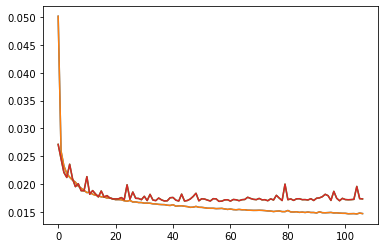

In [21]:
plt.plot(pd.DataFrame(history.history))
plt.show()

## 8. AutoEncoder 모델 테스트
- 테스트 이미지의 오리지널과 인코딩 - 디코딩 후의 이미지를 시각적으로 확인
    - 재구성이 잘된 경우 오리지널과 디코딩 이미지의 차이가 크지 않을 것이다.
    - 즉, 차이가 크지 않다는 것은 latent vector가 이미지의 특징을 잘 추출했다는 것이므로 성공적인 모델이라고 판단할 수 있다.

### 1) Best AutoEncoder 모델 로드

In [22]:
load_model = AutoEncoder(latent_dim)
load_model.load_weights('./2D_AutoEncoder_model/2D_AutoEncoder.ckpt')
load_model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mse'])
load_model.evaluate(test_images, test_images)

66/66 [==============================] - 4s 37ms/step - loss: 0.0169 - mse: 0.0169


[0.016894375905394554, 0.016894375905394554]

### 2) 테스트 이미지를 통한 테스트

In [23]:
encoded_imgs = load_model.encoder(test_images[:100]).numpy()
decoded_imgs = load_model.decoder(encoded_imgs).numpy()

- 10장의 이미지를 테스트한다.

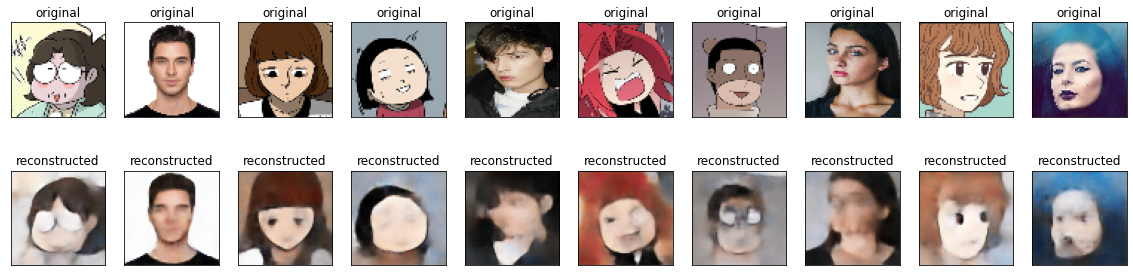

In [24]:
n = 10

plt.figure(figsize=(2 * 10, 5))

for i in range(10):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_images[i])
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i])
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## 9. 이미지간 유사도 비교 테스트
- 본 모델의 최종 목적은 latent 벡터를 통한 이미지 유사도 비교에 있기 때문에 이미지간 유사도 비교 테스트를 진행한다.

In [38]:
# 이미지 전처리 함수 정의 : 모델의 입력 데이터에 맞게 이미지 데이터를 전처리한다. // cv2 형식의 데이터
def image_preprocessing(img):
    img = cv2.resize(img, (64, 64))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.
    
    return img

In [43]:
# 비교할 이미지 불러오기
image_1 = cv2.imread('../version_1.0/image_data/Actor/임수향_32_여.jpg')
image_2 = cv2.imread('../version_1.0/image_data/Actor2Webtoon/webtoon_임수향_32_여.jpg')
image_3 = cv2.imread('../version_1.0/image_data/Webtoon/내 ID는 강남미인!_강미래.jpg')
image_4 = cv2.imread('../version_1.0/image_data/Actor2Webtoon/webtoon_감우성_52_남.jpg')

In [44]:
# 이미지 전처리
conv_image_1 = image_preprocessing(image_1)
conv_image_2 = image_preprocessing(image_2)
conv_image_3 = image_preprocessing(image_3)
conv_image_4 = image_preprocessing(image_4)

In [45]:
# 이미지를 AutoEncoder의 encoder를 통해서 벡터화
vec_image_1 = load_model.encoder(conv_image_1.reshape(1, 64, 64, 3))
vec_image_2 = load_model.encoder(conv_image_2.reshape(1, 64, 64, 3))
vec_image_3 = load_model.encoder(conv_image_3.reshape(1, 64, 64, 3))
vec_image_4 = load_model.encoder(conv_image_4.reshape(1, 64, 64, 3))

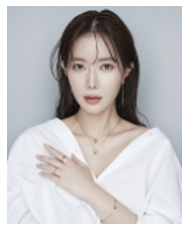

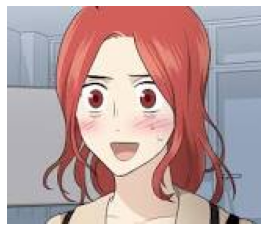

array([[0.9182673]], dtype=float32)

In [36]:
# 이미지 유사도 비교 : 임수향 vs 강미래
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
plt.imshow(cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
cosine_similarity(vec_image_1, vec_image_3)

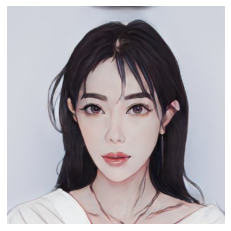

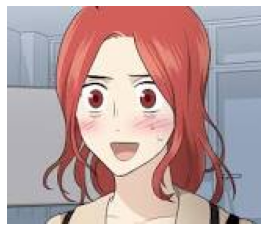

array([[0.9364499]], dtype=float32)

In [37]:
# 이미지 유사도 비교 : 임수향 webtoon vs 강미래 : 유사도가 소폭 상승
plt.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
plt.imshow(cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
cosine_similarity(vec_image_2, vec_image_3)

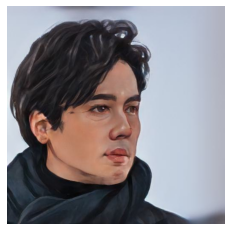

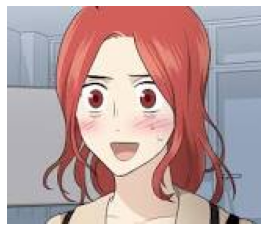

array([[0.83612686]], dtype=float32)

In [46]:
# 이미지 유사도 비교 : 강두리 webtoon vs 강미래
plt.imshow(cv2.cvtColor(image_4, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
plt.imshow(cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
cosine_similarity(vec_image_4, vec_image_3)

## 10. 모델 평가
- Convolution 층을 추가하여 2D AutoEncoder를 구성하니 재구성 오류도 많이 줄어들었고 이미지의 특징을 어느정도 잘 잡아내는 것을 알 수 있다. 학습 데이터가 2만개로 조금 부족하기 때문에 완벽하지는 않지만 Beta 모델에 사용하기에는 적합하다.